## Convolutional Neural Network - with parameter comparisons and history

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torchvision import datasets, transforms, models
from tqdm import tqdm
import time
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import label_binarize


### Define Simple CNN Model

In [3]:
# CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

### Define training process

In [17]:
def trainingCNN(model, tr_loader, va_loader,learning_rate, num_epoch=10):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    history = {"train_loss": [], "valid_loss": [], "valid_accuracy": [], 
               "valid_f1":[], "valid_precision":[], "valid_recall":[], "total_duration":0}
    total_duration = 0

    # Training and Validation Loop
    epochs = num_epoch
    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        for images, labels in tqdm(tr_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", leave=False):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_loss /= len(tr_loader)
        train_precision = precision_score(train_labels, train_preds, average='macro', zero_division=1)
        train_recall = recall_score(train_labels, train_preds, average='macro', zero_division=1)

        # Validation
        model.eval()
        valid_loss = 0
        all_labels = []
        all_preds = []
        with torch.no_grad():
            for images, labels in va_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                valid_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        valid_loss /= len(va_loader)
        valid_accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()
        valid_f1 = f1_score(all_labels, all_preds, average='macro')
        valid_precision = precision_score(all_labels, all_preds, average='macro', zero_division=1)
        valid_recall = recall_score(all_labels, all_preds, average='macro', zero_division=1)

        epoch_duration = time.time() - start_time
        total_duration += epoch_duration

        # Store in history
        history["train_loss"].append(train_loss)
        history["valid_loss"].append(valid_loss)
        history["valid_accuracy"].append(valid_accuracy)
        history["valid_f1"].append(valid_f1)
        history["valid_precision"].append(valid_precision)
        history["valid_recall"].append(valid_recall)

        print(f"Epoch {epoch+1}/{epochs} - Duration: {epoch_duration:.2f}s")
        print(f"Train Loss: {train_loss:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}")
        print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}, Valid F1 Score: {valid_f1:.4f}, Valid Precision: {valid_precision:.4f}, Valid Recall: {valid_recall:.4f}")
    
    history["total_duration"] = total_duration

    return model, history

### Define training Dataloader

In [5]:
def loadTrainingData(i_size, b_size, original=True):
    # Data transformations with augmentation
    train_transforms = transforms.Compose([
        transforms.Resize((i_size, i_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(45),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])

    valid_test_transforms = transforms.Compose([
        transforms.Resize((i_size, i_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])

    # Datasets
    train_dataset = datasets.ImageFolder("butterfly_and_moth_classification/train", transform=train_transforms)
    valid_dataset = datasets.ImageFolder("butterfly_and_moth_classification/valid", transform=valid_test_transforms)
    test_dataset = datasets.ImageFolder("butterfly_and_moth_classification/test", transform=valid_test_transforms)

    # DataLoaders
    batch_size = b_size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    if(original == False):
        train_original = datasets.ImageFolder("butterfly_and_moth_classification/train", transform=valid_test_transforms) # original training set
        augmented_dataset = datasets.ImageFolder("butterfly_and_moth_classification/train", transform=train_transforms) # trainsformed training set
        train_combined = ConcatDataset([train_original, augmented_dataset])
        train_loader = DataLoader(train_combined, batch_size=batch_size, shuffle=True)

    print(f"Training set size: {len(train_loader.dataset)}")
    print(f"Validation set size: {len(valid_loader.dataset)}")
    print(f"Test set size: {len(test_loader.dataset)}")
    
    return train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader

In [6]:
# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set CUDA seed (if using GPU)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)  # for all GPUs

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

**Sub-model 1:**<br>
input size 64 x 64, batch_size = 64, learning rate = 0.001, original training set

In [18]:
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = loadTrainingData(64,64);
num_classes = len(train_dataset.classes)
model = SimpleCNN(num_classes=num_classes)
model_1, history_1 = trainingCNN(model, train_loader, valid_loader, learning_rate=0.001)

Training set size: 12594
Validation set size: 500
Test set size: 500


Epoch 1/10 - Duration: 19.71s
Train Loss: 3.9093, Train Precision: 0.0915, Train Recall: 0.0911
Valid Loss: 2.8170, Valid Accuracy: 0.3140, Valid F1 Score: 0.2625, Valid Precision: 0.5513, Valid Recall: 0.3140


Epoch 2/10 - Duration: 18.96s
Train Loss: 2.8007, Train Precision: 0.2586, Train Recall: 0.2737
Valid Loss: 2.0746, Valid Accuracy: 0.4760, Valid F1 Score: 0.4445, Valid Precision: 0.5924, Valid Recall: 0.4760


Epoch 3/10 - Duration: 18.81s
Train Loss: 2.3069, Train Precision: 0.3672, Train Recall: 0.3777
Valid Loss: 1.7507, Valid Accuracy: 0.5460, Valid F1 Score: 0.5272, Valid Precision: 0.6524, Valid Recall: 0.5460


Epoch 4/10 - Duration: 18.90s
Train Loss: 2.0422, Train Precision: 0.4297, Train Recall: 0.4365
Valid Loss: 1.4717, Valid Accuracy: 0.6120, Valid F1 Score: 0.5891, Valid Precision: 0.6833, Valid Recall: 0.6120


Epoch 5/10 - Duration: 18.89s
Train Loss: 1.8496, Train Precision: 0.4839, Train Recall: 0.4892
Valid Loss: 1.2861, Valid Accuracy: 0.6660, Valid F1 Score: 0.6492, Valid Precision: 0.7140, Valid Recall: 0.6660


Epoch 6/10 - Duration: 18.79s
Train Loss: 1.7186, Train Precision: 0.5157, Train Recall: 0.5187
Valid Loss: 1.1897, Valid Accuracy: 0.6820, Valid F1 Score: 0.6654, Valid Precision: 0.7075, Valid Recall: 0.6820


Epoch 7/10 - Duration: 19.12s
Train Loss: 1.6263, Train Precision: 0.5401, Train Recall: 0.5441
Valid Loss: 1.1719, Valid Accuracy: 0.6920, Valid F1 Score: 0.6811, Valid Precision: 0.7728, Valid Recall: 0.6920


Epoch 8/10 - Duration: 19.49s
Train Loss: 1.5341, Train Precision: 0.5616, Train Recall: 0.5633
Valid Loss: 1.0805, Valid Accuracy: 0.7020, Valid F1 Score: 0.6859, Valid Precision: 0.7642, Valid Recall: 0.7020


Epoch 9/10 - Duration: 18.55s
Train Loss: 1.4675, Train Precision: 0.5769, Train Recall: 0.5789
Valid Loss: 0.9849, Valid Accuracy: 0.7460, Valid F1 Score: 0.7329, Valid Precision: 0.7732, Valid Recall: 0.7460


Epoch 10/10 - Duration: 18.61s
Train Loss: 1.4154, Train Precision: 0.5930, Train Recall: 0.5934
Valid Loss: 1.0143, Valid Accuracy: 0.7220, Valid F1 Score: 0.7118, Valid Precision: 0.7780, Valid Recall: 0.7220


**Sub-model 2:**<br>
input size 64 x 64, batch_size = 64, learning rate = 0.0001, original training set

In [25]:
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = loadTrainingData(64,64);
num_classes = len(train_dataset.classes)
model = SimpleCNN(num_classes=num_classes)
model_2, history_2 = trainingCNN(model, train_loader, valid_loader, learning_rate=0.0001, num_epoch=10)

Training set size: 12594
Validation set size: 500
Test set size: 500


Epoch 1/10 - Duration: 20.07s
Train Loss: 4.4869, Train Precision: 0.0504, Train Recall: 0.0276
Valid Loss: 4.1222, Valid Accuracy: 0.0780, Valid F1 Score: 0.0336, Valid Precision: 0.6508, Valid Recall: 0.0780


Epoch 2/10 - Duration: 19.06s
Train Loss: 4.0733, Train Precision: 0.0589, Train Recall: 0.0662
Valid Loss: 3.6208, Valid Accuracy: 0.1560, Valid F1 Score: 0.1026, Valid Precision: 0.6005, Valid Recall: 0.1560


Epoch 3/10 - Duration: 18.99s
Train Loss: 3.7095, Train Precision: 0.1001, Train Recall: 0.1131
Valid Loss: 3.1933, Valid Accuracy: 0.2440, Valid F1 Score: 0.1958, Valid Precision: 0.5049, Valid Recall: 0.2440


Epoch 4/10 - Duration: 19.61s
Train Loss: 3.4061, Train Precision: 0.1462, Train Recall: 0.1571
Valid Loss: 2.8893, Valid Accuracy: 0.3240, Valid F1 Score: 0.2704, Valid Precision: 0.4882, Valid Recall: 0.3240


Epoch 5/10 - Duration: 18.66s
Train Loss: 3.1748, Train Precision: 0.1869, Train Recall: 0.2015
Valid Loss: 2.6590, Valid Accuracy: 0.3860, Valid F1 Score: 0.3329, Valid Precision: 0.5283, Valid Recall: 0.3860


Epoch 6/10 - Duration: 19.29s
Train Loss: 2.9939, Train Precision: 0.2175, Train Recall: 0.2297
Valid Loss: 2.4533, Valid Accuracy: 0.4220, Valid F1 Score: 0.3756, Valid Precision: 0.4898, Valid Recall: 0.4220


Epoch 7/10 - Duration: 18.96s
Train Loss: 2.8275, Train Precision: 0.2604, Train Recall: 0.2712
Valid Loss: 2.3130, Valid Accuracy: 0.4720, Valid F1 Score: 0.4284, Valid Precision: 0.5564, Valid Recall: 0.4720


Epoch 8/10 - Duration: 18.62s
Train Loss: 2.6904, Train Precision: 0.2877, Train Recall: 0.2992
Valid Loss: 2.1650, Valid Accuracy: 0.4820, Valid F1 Score: 0.4500, Valid Precision: 0.5263, Valid Recall: 0.4820


Epoch 9/10 - Duration: 18.57s
Train Loss: 2.5888, Train Precision: 0.3054, Train Recall: 0.3181
Valid Loss: 2.0465, Valid Accuracy: 0.5160, Valid F1 Score: 0.4864, Valid Precision: 0.5650, Valid Recall: 0.5160


Epoch 10/10 - Duration: 18.58s
Train Loss: 2.5005, Train Precision: 0.3299, Train Recall: 0.3390
Valid Loss: 1.9606, Valid Accuracy: 0.5260, Valid F1 Score: 0.4883, Valid Precision: 0.5646, Valid Recall: 0.5260


**Sub-model 3:**<br>
input size 64 x 64, batch_size = 128, learning rate = 0.001, original training set

In [26]:
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = loadTrainingData(64,b_size=128);
num_classes = len(train_dataset.classes)
model = SimpleCNN(num_classes=num_classes)
model_3 ,history_3 = trainingCNN(model, train_loader, valid_loader, learning_rate=0.001)

Training set size: 12594
Validation set size: 500
Test set size: 500


Epoch 1/10 - Duration: 17.71s
Train Loss: 4.1588, Train Precision: 0.0569, Train Recall: 0.0568
Valid Loss: 3.3943, Valid Accuracy: 0.1940, Valid F1 Score: 0.1512, Valid Precision: 0.5395, Valid Recall: 0.1940


Epoch 2/10 - Duration: 17.10s
Train Loss: 3.2614, Train Precision: 0.1707, Train Recall: 0.1863
Valid Loss: 2.5659, Valid Accuracy: 0.3740, Valid F1 Score: 0.3397, Valid Precision: 0.5144, Valid Recall: 0.3740


Epoch 3/10 - Duration: 17.04s
Train Loss: 2.7008, Train Precision: 0.2840, Train Recall: 0.2967
Valid Loss: 2.0838, Valid Accuracy: 0.4620, Valid F1 Score: 0.4288, Valid Precision: 0.5690, Valid Recall: 0.4620


Epoch 4/10 - Duration: 17.13s
Train Loss: 2.3098, Train Precision: 0.3719, Train Recall: 0.3822
Valid Loss: 1.7620, Valid Accuracy: 0.5540, Valid F1 Score: 0.5324, Valid Precision: 0.6157, Valid Recall: 0.5540


Epoch 5/10 - Duration: 17.31s
Train Loss: 2.1148, Train Precision: 0.4144, Train Recall: 0.4229
Valid Loss: 1.6239, Valid Accuracy: 0.5920, Valid F1 Score: 0.5650, Valid Precision: 0.6428, Valid Recall: 0.5920


Epoch 6/10 - Duration: 17.35s
Train Loss: 1.9418, Train Precision: 0.4562, Train Recall: 0.4629
Valid Loss: 1.4153, Valid Accuracy: 0.6400, Valid F1 Score: 0.6257, Valid Precision: 0.6881, Valid Recall: 0.6400


Epoch 7/10 - Duration: 17.17s
Train Loss: 1.8072, Train Precision: 0.4924, Train Recall: 0.4988
Valid Loss: 1.3640, Valid Accuracy: 0.6560, Valid F1 Score: 0.6412, Valid Precision: 0.6790, Valid Recall: 0.6560


Epoch 8/10 - Duration: 17.11s
Train Loss: 1.7538, Train Precision: 0.5084, Train Recall: 0.5129
Valid Loss: 1.2663, Valid Accuracy: 0.6480, Valid F1 Score: 0.6327, Valid Precision: 0.6623, Valid Recall: 0.6480


Epoch 9/10 - Duration: 17.07s
Train Loss: 1.6530, Train Precision: 0.5295, Train Recall: 0.5324
Valid Loss: 1.2269, Valid Accuracy: 0.6780, Valid F1 Score: 0.6652, Valid Precision: 0.7163, Valid Recall: 0.6780


Epoch 10/10 - Duration: 17.18s
Train Loss: 1.6005, Train Precision: 0.5454, Train Recall: 0.5488
Valid Loss: 1.1406, Valid Accuracy: 0.6920, Valid F1 Score: 0.6779, Valid Precision: 0.7270, Valid Recall: 0.6920


**Sub-model 4:**<br>
input size 64 x 64, batch_size = 64, learning rate = 0.001, expanded training set

In [27]:
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = loadTrainingData(64,64,False);
num_classes = len(train_dataset.classes)
model = SimpleCNN(num_classes=num_classes)
model_4, history_4 = trainingCNN(model, train_loader, valid_loader, learning_rate=0.001)

Training set size: 25188
Validation set size: 500
Test set size: 500


Epoch 1/10 - Duration: 34.44s
Train Loss: 3.4288, Train Precision: 0.1637, Train Recall: 0.1683
Valid Loss: 2.0746, Valid Accuracy: 0.4420, Valid F1 Score: 0.4101, Valid Precision: 0.5257, Valid Recall: 0.4420


Epoch 2/10 - Duration: 33.97s
Train Loss: 2.2306, Train Precision: 0.3859, Train Recall: 0.3956
Valid Loss: 1.4548, Valid Accuracy: 0.6360, Valid F1 Score: 0.6212, Valid Precision: 0.7039, Valid Recall: 0.6360


Epoch 3/10 - Duration: 35.31s
Train Loss: 1.7969, Train Precision: 0.4957, Train Recall: 0.5016
Valid Loss: 1.2524, Valid Accuracy: 0.6980, Valid F1 Score: 0.6808, Valid Precision: 0.7286, Valid Recall: 0.6980


Epoch 4/10 - Duration: 33.56s
Train Loss: 1.5641, Train Precision: 0.5532, Train Recall: 0.5564
Valid Loss: 1.0489, Valid Accuracy: 0.7220, Valid F1 Score: 0.7122, Valid Precision: 0.7659, Valid Recall: 0.7220


Epoch 5/10 - Duration: 33.76s
Train Loss: 1.4076, Train Precision: 0.5934, Train Recall: 0.5958
Valid Loss: 0.9134, Valid Accuracy: 0.7600, Valid F1 Score: 0.7481, Valid Precision: 0.8030, Valid Recall: 0.7600


Epoch 6/10 - Duration: 33.79s
Train Loss: 1.2756, Train Precision: 0.6271, Train Recall: 0.6290
Valid Loss: 0.8519, Valid Accuracy: 0.7480, Valid F1 Score: 0.7374, Valid Precision: 0.7879, Valid Recall: 0.7480


Epoch 7/10 - Duration: 33.68s
Train Loss: 1.1865, Train Precision: 0.6497, Train Recall: 0.6508
Valid Loss: 0.8358, Valid Accuracy: 0.7840, Valid F1 Score: 0.7753, Valid Precision: 0.8174, Valid Recall: 0.7840


Epoch 8/10 - Duration: 33.66s
Train Loss: 1.0840, Train Precision: 0.6769, Train Recall: 0.6785
Valid Loss: 0.7996, Valid Accuracy: 0.7880, Valid F1 Score: 0.7820, Valid Precision: 0.8196, Valid Recall: 0.7880


Epoch 9/10 - Duration: 33.87s
Train Loss: 1.0245, Train Precision: 0.6922, Train Recall: 0.6925
Valid Loss: 0.7490, Valid Accuracy: 0.7920, Valid F1 Score: 0.7865, Valid Precision: 0.8203, Valid Recall: 0.7920


Epoch 10/10 - Duration: 33.88s
Train Loss: 0.9712, Train Precision: 0.7084, Train Recall: 0.7096
Valid Loss: 0.7745, Valid Accuracy: 0.7860, Valid F1 Score: 0.7779, Valid Precision: 0.8158, Valid Recall: 0.7860


**Sub-model 5:**<br>
input size 128 x 128, batch_size = 64, learning rate = 0.001, original training set

In [28]:
# CNN Model
class SimpleCNN_2(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN_2, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [29]:
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = loadTrainingData(i_size=128,b_size=64);
num_classes = len(train_dataset.classes)
model = SimpleCNN_2(num_classes=num_classes)
model_5, history_5 = trainingCNN(model, train_loader, valid_loader, learning_rate=0.001)

Training set size: 12594
Validation set size: 500
Test set size: 500


Epoch 1/10 - Duration: 39.19s
Train Loss: 4.0843, Train Precision: 0.0717, Train Recall: 0.0706
Valid Loss: 3.1621, Valid Accuracy: 0.2620, Valid F1 Score: 0.2101, Valid Precision: 0.5111, Valid Recall: 0.2620


Epoch 2/10 - Duration: 43.34s
Train Loss: 3.0913, Train Precision: 0.1919, Train Recall: 0.2053
Valid Loss: 2.3349, Valid Accuracy: 0.4140, Valid F1 Score: 0.3893, Valid Precision: 0.5418, Valid Recall: 0.4140


Epoch 3/10 - Duration: 43.26s
Train Loss: 2.5557, Train Precision: 0.3126, Train Recall: 0.3240
Valid Loss: 1.9189, Valid Accuracy: 0.5160, Valid F1 Score: 0.4918, Valid Precision: 0.5806, Valid Recall: 0.5160


Epoch 4/10 - Duration: 43.30s
Train Loss: 2.3033, Train Precision: 0.3622, Train Recall: 0.3733
Valid Loss: 1.6516, Valid Accuracy: 0.5860, Valid F1 Score: 0.5666, Valid Precision: 0.6545, Valid Recall: 0.5860


Epoch 5/10 - Duration: 43.44s
Train Loss: 2.1076, Train Precision: 0.4080, Train Recall: 0.4157
Valid Loss: 1.4843, Valid Accuracy: 0.5980, Valid F1 Score: 0.5841, Valid Precision: 0.6753, Valid Recall: 0.5980


Epoch 6/10 - Duration: 43.37s
Train Loss: 1.9733, Train Precision: 0.4425, Train Recall: 0.4484
Valid Loss: 1.3262, Valid Accuracy: 0.6420, Valid F1 Score: 0.6301, Valid Precision: 0.6886, Valid Recall: 0.6420


Epoch 7/10 - Duration: 43.37s
Train Loss: 1.8824, Train Precision: 0.4668, Train Recall: 0.4728
Valid Loss: 1.3295, Valid Accuracy: 0.6560, Valid F1 Score: 0.6449, Valid Precision: 0.7374, Valid Recall: 0.6560


Epoch 8/10 - Duration: 44.73s
Train Loss: 1.7957, Train Precision: 0.4902, Train Recall: 0.4947
Valid Loss: 1.1427, Valid Accuracy: 0.6760, Valid F1 Score: 0.6563, Valid Precision: 0.6923, Valid Recall: 0.6760


Epoch 9/10 - Duration: 43.26s
Train Loss: 1.6987, Train Precision: 0.5129, Train Recall: 0.5179
Valid Loss: 1.1830, Valid Accuracy: 0.6760, Valid F1 Score: 0.6530, Valid Precision: 0.7265, Valid Recall: 0.6760


Epoch 10/10 - Duration: 44.14s
Train Loss: 1.6564, Train Precision: 0.5224, Train Recall: 0.5266
Valid Loss: 1.0537, Valid Accuracy: 0.7260, Valid F1 Score: 0.7079, Valid Precision: 0.7596, Valid Recall: 0.7260


==================================================================

### Evaluation

In [33]:
models_list = [("model_1", model_1), ("model_2", model_2), ("model_3", model_3), ("model_4", model_4), ("model_5", model_5)]
models_histories = [("model_1", history_1), ("model_2", history_2), ("model_3", history_3), ("model_4", history_4), ("model_5", history_5)]

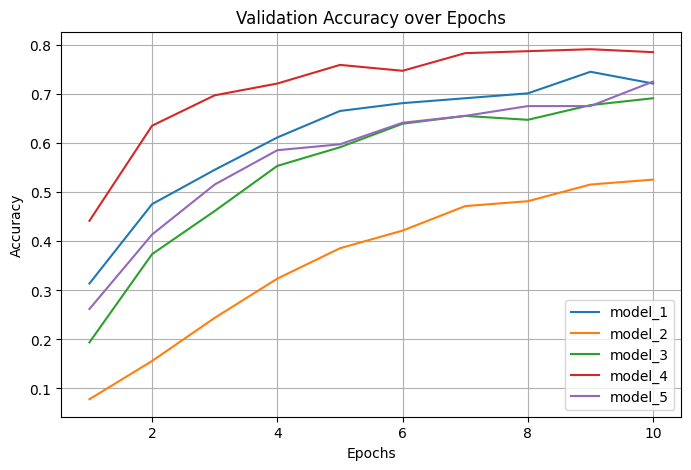

In [34]:
# Plot Validation Accuracy
plt.figure(figsize=(8, 5))
for name, history in models_histories:
    plt.plot(range(1, 11), history["valid_accuracy"], label=name)
plt.title("Validation Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()